<a href="https://colab.research.google.com/github/sunny722122/capitalstone_Proj_malaria_detection/blob/main/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Drive

In [56]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
# Mounting the drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load libraries

In [58]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU

from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [59]:
# Importing libraries required to load the data
import zipfile

import os

from PIL import Image

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf

from tensorflow.keras import optimizers

# To ignore warnings
import warnings

warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)

pd.set_option("display.max_rows", 200)

Load data

In [60]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/cell_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:

    zip_ref.extractall()

In [61]:
# Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

# Size of image so that each image has the same size
SIZE = 64

# Empty list to store the training images after they are converted to NumPy arrays
train_images = []

# Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [62]:
for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
    
        try:
    
            # Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))

            # Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':
                
                train_labels.append(1)
            
            else:
            
                train_labels.append(0)
        
        except Exception:
        
            pass       

# Converting lists to arrays
train_images = np.array(train_images)

train_labels = np.array(train_labels)

In [63]:
# Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

# Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

# Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

# Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [64]:
for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
     
        try:
            # Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))
            
            # Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':
                
                test_labels.append(1)
            
            else:
            
                test_labels.append(0)
        
        except Exception:
        
            pass       

# Converting lists to arrays
test_images = np.array(test_images)

test_labels = np.array(test_labels)

Normalize data

In [65]:
# Try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images = (train_images/255).astype('float32')

test_images = (test_images/255).astype('float32')

# **Vision transformers**

**Configure the hyperparameters**

In [66]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 64  # We'll resize input images to this size
patch_size=4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [67]:
num_classes = 100
input_shape = (64, 64, 3)

Use data augmentation

In [68]:
data_augmentation = Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_images)

Implement multilayer perceptron (MLP)

In [69]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Implement patch creation as a layer

In [70]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Display patches for a sample image

Image size: 64 X 64
Patch size: 4 X 4
Patches per image: 256
Elements per patch: 48


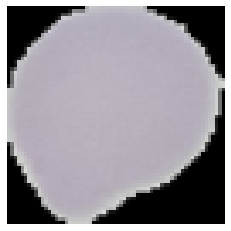

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = train_images[np.random.choice(range(train_images.shape[0]))]
plt.imshow(image)
plt.axis("off")
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

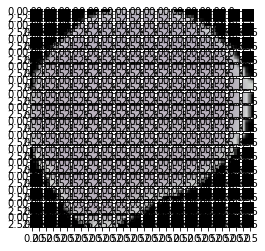

In [72]:
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())

Implement the patch encoding layer The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [73]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# **Build the ViT model**

In [74]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Compile, train, and evaluate the mode

In [75]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=train_images,
        y=train_labels,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[EarlyStopping(monitor = 'val_loss', patience = 2),checkpoint_callback],
        verbose = 1
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test_images, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history,model


vit_classifier = create_vit_classifier()


In [76]:
history3,model = run_experiment(vit_classifier)

Epoch 1/100
88/88 [==============================] - 937s 10s/step - loss: 2.0074 - accuracy: 0.5621 - top-5-accuracy: 0.9886 - val_loss: 0.7070 - val_accuracy: 0.5737 - val_top-5-accuracy: 1.0000
Epoch 2/100
88/88 [==============================] - 906s 10s/step - loss: 0.6830 - accuracy: 0.6041 - top-5-accuracy: 1.0000 - val_loss: 0.7651 - val_accuracy: 0.5000 - val_top-5-accuracy: 1.0000
Epoch 3/100
88/88 [==============================] - 893s 10s/step - loss: 0.4513 - accuracy: 0.7825 - top-5-accuracy: 1.0000 - val_loss: 0.1368 - val_accuracy: 0.9339 - val_top-5-accuracy: 1.0000
Epoch 4/100
88/88 [==============================] - 923s 11s/step - loss: 0.1285 - accuracy: 0.9601 - top-5-accuracy: 1.0000 - val_loss: 0.1781 - val_accuracy: 0.9503 - val_top-5-accuracy: 1.0000
Epoch 5/100
88/88 [==============================] - 941s 11s/step - loss: 0.1166 - accuracy: 0.9641 - top-5-accuracy: 1.0000 - val_loss: 0.0427 - val_accuracy: 0.9768 - val_top-5-accuracy: 1.0000
Epoch 6/100
88/

One Hot Encoding on the train and test labels

In [77]:
# Encoding Train Labels
train_labels = tf.keras.utils.to_categorical(train_labels, 2)

# Similarly let us try to encode test labels
test_labels = tf.keras.utils.to_categorical(test_labels, 2)

<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1300
           1       0.98      0.96      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



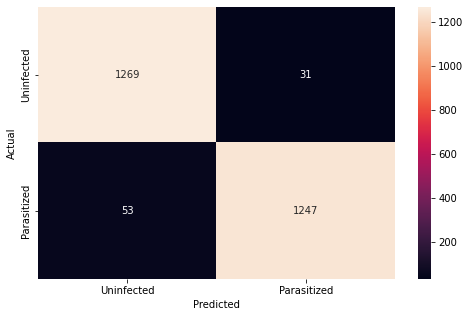

In [78]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

Plotting the train and validation curves

In [79]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

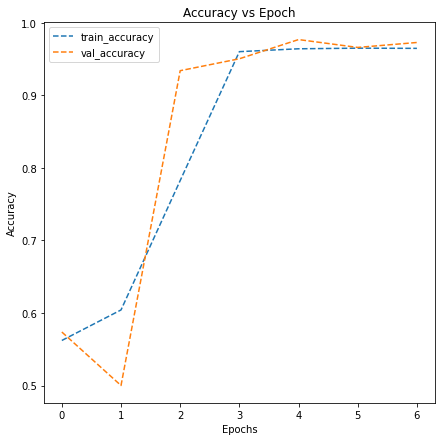

In [80]:
plot_accuracy(history3)